> Martin Fridrich, 03/2022 

# Final project


In [1]:
# # try to resolve lgbm on gpu
# def check_lgbm_gpu():
#   import numpy
#   import lightgbm
#   print("Testing LGBM & GPU compliance...")
#   try:
#     lightgbm.LGBMClassifier(device="gpu").\
#       fit(numpy.array([0,1]).reshape(-1,1),[1,0])
#     print("Great Success!")
#     return True
#   except:
#     print("LGBM not GPU compliant.")
#     return False
# if not(check_lgbm_gpu()):
#   print("Resolving the issues...")
#   !pip uninstall -y lightgbm
#   !pip install lightgbm --install-option=--gpu
#   check_lgbm_gpu()
#   exit() # restart the runtime to prevent loading the old pkg version

In [2]:
#!pip install --upgrade spacy
#!spacy download ru_core_news_md	

In [3]:
# mount project dir
from google.colab import drive
drive.mount("/content/gdrive",  force_remount=True)
%cd gdrive/My Drive/Colab/
#!git clone  https://github.com/fridrichmrtn/hse-advanced-machine-learning
%cd hse-advanced-machine-learning
!git pull
%cd 02_competitive_data_science 
!pip install -r requirements.txt

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab
/content/gdrive/My Drive/Colab/hse-advanced-machine-learning
Updating 2a2e58f..c157704
error: Your local changes to the following files would be overwritten by merge:
	02_competitive_data_science/requirements.txt
	02_competitive_data_science/wk06/final_project.ipynb
Please commit your changes or stash them before you merge.
Aborting
/content/gdrive/My Drive/Colab/hse-advanced-machine-learning/02_competitive_data_science


In [4]:
# set kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Personal/.kaggle"
# download data
!mkdir -p data/final_project
%cd data/final_project
!kaggle competitions download -c competitive-data-science-predict-future-sales
# unpack and remove zips
import os
import glob
for f in glob.glob('*.{}'.format("zip")):
  os.system("unzip "+f); os.system("rm "+f)
# get back
%cd /content/gdrive/MyDrive/Colab/hse-advanced-machine-learning/02_competitive_data_science

/content/gdrive/My Drive/Colab/hse-advanced-machine-learning/02_competitive_data_science/data/final_project
 33% 5.00M/15.1M [00:00<00:00, 52.1MB/s]
100% 15.1M/15.1M [00:00<00:00, 92.5MB/s]
/content/gdrive/MyDrive/Colab/hse-advanced-machine-learning/02_competitive_data_science


## Data loading

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
import gc
from itertools import product
import re
from fuzzywuzzy import fuzz

In [6]:
DATA_DIR = "data/final_project/"
# sales
sales_train = pd.read_csv(DATA_DIR+"sales_train.csv")
sales_test = pd.read_csv(DATA_DIR+"test.csv")
# addional info
items = pd.read_csv(DATA_DIR+"items.csv")
item_categories = pd.read_csv(DATA_DIR+"item_categories.csv")
shops = pd.read_csv(DATA_DIR+"shops.csv")

# basic stats related to sales tab
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


## Initial transformations

In [7]:
# downcast dataframe
def optimize_numeric_dtypes(df):
    import pandas as pd
    float_cols = df.select_dtypes("float").columns
    int_cols = df.select_dtypes("integer").columns
    df[float_cols] = df[float_cols].\
        apply(pd.to_numeric, downcast="float")
    df[int_cols] = df[int_cols].\
        apply(pd.to_numeric, downcast="integer")
    return df

def optimize_categories(df):
    import pandas as pd
    cat_cols = df.select_dtypes("object").columns
    df[cat_cols] = df[cat_cols].\
        apply(lambda x: x.astype("category").cat.codes)
    return df    

In [8]:
# duplicate shops
shop_duplicates_map = {0: 57, 1: 58, 11: 10, 40: 39}
sales_train["shop_id"] = sales_train["shop_id"].replace(shop_duplicates_map)
# datetime
sales_train["date"] = pd.to_datetime(sales_train["date"], format="%d.%m.%Y")
# drop training items with extreme or negative prices or sales counts
sales_train = sales_train[((sales_train["item_price"] > 0) & (sales_train["item_price"] <= 50000)) &
    ((sales_train["item_cnt_day"] > 0) & (sales_train["item_cnt_day"] <= 1000))]
# test-based cartesian product & inds
sales_index = pd.DataFrame(product(sales_test.item_id.unique(), sales_test.shop_id.unique(),
    range(35)),columns = ["item_id", "shop_id", "date_block_num"])
sales_index = optimize_numeric_dtypes(sales_index)
# sales table
sales_train["revenue"] = sales_train["item_price"]*sales_train["item_cnt_day"]
sales = sales_train.groupby(["shop_id", "item_id", "date_block_num"], as_index=False).agg(
    total_sold=("item_cnt_day", sum),  sum_revenue=("revenue",sum),
    n_transactions = ("item_cnt_day",pd.Series.count))\
        .sort_values("date_block_num")
# remove items with less than 10 transactions
sales = sales.loc[sales.groupby("item_id").n_transactions.\
  filter(lambda x: sum(x)>9).index,:]

sales = sales_index.merge(sales, how="left",
    on=["shop_id", "item_id", "date_block_num"])
sales["date_block_num"].fillna(34, inplace=True)
sales.loc[sales.date_block_num<34, ["total_sold", "sum_revenue", "n_transactions"]]=\
    sales.loc[sales.date_block_num<34, ["total_sold", "sum_revenue", "n_transactions"]].fillna(0)  
sales = optimize_numeric_dtypes(sales)
del sales_train, sales_test, sales_index; gc.collect(); sales.head(3)   

,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions
0,5037,5,0,0.0,0.0,0.0
1,5037,5,1,0.0,0.0,0.0
2,5037,5,2,0.0,0.0,0.0


## Exploration

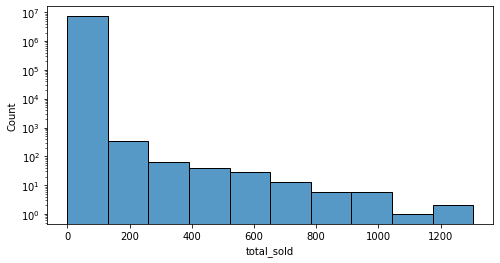

In [9]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
hist = sns.histplot(data=sales, x="total_sold", bins=10,
    palette=sns.color_palette("husl"))
hist.set_yscale("log")

In [10]:
# top 5 items
sales.groupby("item_id")["total_sold"].sum().\
    sort_values(ascending=False).head(5)

item_id
20949    154788.0
2808      14016.0
3732      13630.0
17717     13557.0
5822      12303.0
Name: total_sold, dtype: float32

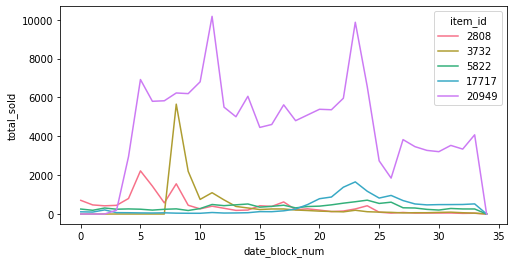

In [11]:
# targets per top 5 items over time
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.lineplot(data=sales[sales.item_id.isin([20949,2808,3732,17717,5822])].\
        groupby(["item_id","date_block_num"], as_index=False)["total_sold"].sum(),
    x="date_block_num", y="total_sold", hue="item_id",
    palette=sns.color_palette("husl", 5));    

In [12]:
# top 5 shops
sales.groupby("shop_id")["total_sold"].sum().\
    sort_values(ascending=False).head(5)

shop_id
31    160068.0
25    123496.0
28    100034.0
42     82964.0
57     69985.0
Name: total_sold, dtype: float32

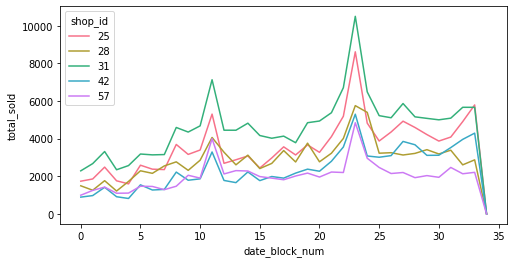

In [13]:
# targets per top 5 items over time
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.lineplot(data=sales[sales.shop_id.isin([31,25,28,42,57])].\
        groupby(["shop_id","date_block_num"], as_index=False)["total_sold"].sum(),
    x="date_block_num", y="total_sold", hue="shop_id",
    palette=sns.color_palette("husl", 5));    

In [14]:
# top 5 categories
sales.merge(items).groupby("item_category_id")["total_sold"].sum().\
    sort_values(ascending=False).head(5)

item_category_id
30    221393.0
55    179562.0
40    156118.0
71    154788.0
19    110217.0
Name: total_sold, dtype: float32

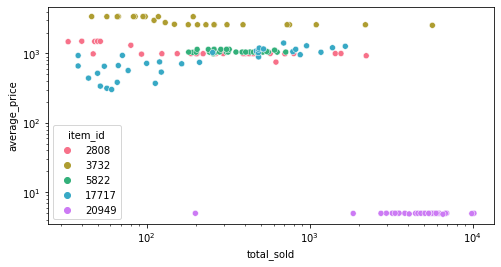

In [15]:
# price vs sales, demand almost inelastic
df = sales[sales.item_id.isin([20949,2808,3732,17717,5822])].\
        groupby(["item_id", "date_block_num"], as_index=False).\
            agg(sum_revenue=("sum_revenue",sum),
            total_sold=("total_sold",sum))
df["average_price"] = df.sum_revenue/df.total_sold
fig, ax = plt.subplots(1,1,figsize=(8,4))
scatter = sns.scatterplot(data=df, x="total_sold", y="average_price",
    hue="item_id", palette=sns.color_palette("husl", 5));
scatter.set_yscale("log"); scatter.set_xscale("log");

## Feature engineering

In [16]:
# item groups based on adjacency and label similarity
items.item_name = items.item_name.apply(lambda x: re.sub("[^A-ZА-Яa-zа-я0-9 ]","", x))
items.item_name = items.item_name.apply(lambda x: re.sub("\\s+"," ", x))
item_names = pd.concat([items.item_id, items.item_name,
    items.item_id.shift().fillna(0), items.item_name.shift().fillna("")], axis=1)
item_names.columns = ["item_id", "item_name", "previous_item_id", "previous_item_name"]
item_names["similarity"] = item_names.apply(\
     lambda x: fuzz.ratio(x["item_name"],x["previous_item_name"]), axis=1)
item_names["group_start"] = item_names["similarity"] <= 75
item_group_map = item_names.loc[item_names.group_start, ["item_id"]]
item_group_map.columns = ["group_start"]
item_group_map["group_end"] = item_group_map["group_start"].shift(-1).\
    fillna(item_group_map["group_start"].max()+1).astype("int")
item_group_map["item_sim_id"] = list(range(len(item_group_map)))
# remap
items = items.merge(item_group_map, how="left",
    left_on=["item_id"], right_on=["group_start"])
items = items.sort_values("item_id")
items["item_sim_id"] = items["item_sim_id"].fillna(method="ffill").astype("int")
del item_names, item_group_map; gc.collect()
items = items[["item_id","item_name", "item_category_id", "item_sim_id"]]
# name length
items["item_name_len"] = items.item_name.apply(len).astype("int16")
# just add some additional text-based features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
# add some textual features
tfvec = TfidfVectorizer()
tfdf = tfvec.fit_transform(items["item_name"])
pca = PCA(n_components=5)
tf_cols = ["item_tf_"+str(c) for c in range(5)]
pcadf = pd.DataFrame(pca.fit_transform(tfdf.toarray()),
  columns=tf_cols, index=items.index)
items = pd.concat([items, pcadf], axis=1)
items.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,item_id,item_name,item_category_id,item_sim_id,item_name_len,item_tf_0,item_tf_1,item_tf_2,item_tf_3,item_tf_4
0,0,ВО ВЛАСТИ НАВАЖДЕНИЯ ПЛАСТ D,40,0,29,-0.033850,-0.012470,-0.003026,-0.021130,-0.012571
1,1,ABBYY FineReader 12 Professional Edition Full ...,76,1,64,0.258495,0.058239,-0.102291,0.014972,-0.048726
2,2,В ЛУЧАХ СЛАВЫ UNV D,40,2,19,-0.033938,-0.012152,-0.002975,-0.020785,-0.013740


In [17]:
# categories
cat_splits = item_categories.item_category_name.apply(lambda x: x.split(" - "))
item_categories = pd.concat([item_categories,
    pd.DataFrame([c if len(c)>1 else [c[0],""] for c in cat_splits],
        columns=["parent_cat","child_cat"])], axis=1)
items = items.merge(item_categories, how="inner")
# return categorical encoding
items = optimize_categories(items[["item_id", "item_category_id", "item_sim_id",
    "item_name_len", "parent_cat", "child_cat"]+tf_cols])
# add categories
sales = sales.merge(items, how="inner", on="item_id")
sales["shop_cat_id"] = sales.shop_id*100+sales.item_category_id
del item_categories, items; gc.collect(); sales.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,child_cat,item_tf_0,item_tf_1,item_tf_2,item_tf_3,item_tf_4,shop_cat_id
0,5037,5,0,0.0,0.0,0.0,19,3286,27,5,13,0.020646,-0.072941,0.170727,-0.015652,0.061791,7
1,5037,5,1,0.0,0.0,0.0,19,3286,27,5,13,0.020646,-0.072941,0.170727,-0.015652,0.061791,7
2,5037,5,2,0.0,0.0,0.0,19,3286,27,5,13,0.020646,-0.072941,0.170727,-0.015652,0.061791,7


In [18]:
# date features
def working_days_count(from_date, to_date=None):
    import pandas as pd
    if to_date is None:
        to_date=from_date+pd.DateOffset(months=1)
    temp_date=from_date
    cnt=0
    while temp_date<to_date:
        if temp_date.weekday()<5:
            cnt+=1
        temp_date+=pd.DateOffset(days=1)
    return ((to_date-from_date).days, cnt, (to_date-from_date).days-cnt)
dates = pd.DataFrame(sales.date_block_num.unique(), columns=["date_block_num"])
dates["date"] = dates["date_block_num"].apply(lambda x: pd.to_datetime("01/01/2013")+\
    pd.DateOffset(months=x))
dates["year"] = dates.date.dt.year
dates["month"] = dates.date.dt.month
dates = optimize_numeric_dtypes(pd.concat([dates, pd.DataFrame.from_records(
        dates["date"].apply(lambda x: working_days_count(x)),
    columns=["total_days", "working_days", "weekend_days"])], axis=1))
sales = sales.merge(dates[["date_block_num","year","month","total_days", "working_days",
    "weekend_days"]], how="inner", on="date_block_num")
del dates; gc.collect(); sales.tail(3)    

,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,...,item_tf_1,item_tf_2,item_tf_3,item_tf_4,shop_cat_id,year,month,total_days,working_days,weekend_days
7496997,969,44,34,NaN,NaN,NaN,37,646,20,11,...,0.210027,0.020103,0.053651,0.030143,85,2015,11,30,21,9
7496998,969,39,34,NaN,NaN,NaN,37,646,20,11,...,0.210027,0.020103,0.053651,0.030143,97,2015,11,30,21,9
7496999,969,45,34,NaN,NaN,NaN,37,646,20,11,...,0.210027,0.020103,0.053651,0.030143,-71,2015,11,30,21,9


In [19]:
# pricing overall and inside cat
item_pricing = sales.groupby(["date_block_num","item_id","item_category_id"], as_index=False).\
    agg(total_sold=("total_sold", sum),  sum_revenue=("sum_revenue",sum))
train_ind = item_pricing.date_block_num<34
item_pricing.loc[train_ind,"average_price"] = item_pricing["sum_revenue"]/item_pricing["total_sold"]
item_pricing.loc[train_ind,"average_price"]  = item_pricing.groupby(["item_id"])["average_price"].\
    apply(lambda x: x.fillna(method="ffill").fillna(method="bfill"))
# add price changes
item_pricing.loc[train_ind,"price_change"] = item_pricing.groupby(["item_id"])["average_price"].\
    apply(lambda x: x/x.shift()).fillna(-1)
# add position within the category
item_pricing.loc[train_ind,"price_perc"] = item_pricing.groupby(["item_category_id", "date_block_num"])\
    ["average_price"].apply(lambda x: x.rank(pct=True)).fillna(-1)
item_pricing = optimize_numeric_dtypes(item_pricing[["date_block_num", "item_id", "price_change",
    "price_perc"]])
sales = sales.merge(item_pricing, how="left",
    on=["date_block_num", "item_id"])
del item_pricing; gc.collect(); sales.tail(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,...,item_tf_3,item_tf_4,shop_cat_id,year,month,total_days,working_days,weekend_days,price_change,price_perc
7496997,969,44,34,NaN,NaN,NaN,37,646,20,11,...,0.053651,0.030143,85,2015,11,30,21,9,NaN,NaN
7496998,969,39,34,NaN,NaN,NaN,37,646,20,11,...,0.053651,0.030143,97,2015,11,30,21,9,NaN,NaN
7496999,969,45,34,NaN,NaN,NaN,37,646,20,11,...,0.053651,0.030143,-71,2015,11,30,21,9,NaN,NaN


In [20]:
# shop location
shops["city_id"] = shops.shop_name.apply(lambda x:\
    re.sub("[^A-ZА-Яa-zа-я0-9 ]","", x.split(" ")[0]))
shops = optimize_categories(shops[["city_id","shop_id"]])
shops["shop_city_id"] = 100*shops.shop_id+shops.city_id
sales = sales.merge(shops, how="inner", on="shop_id")
del shops; gc.collect(); sales.tail(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,...,shop_cat_id,year,month,total_days,working_days,weekend_days,price_change,price_perc,city_id,shop_city_id
7496997,15757,45,34,NaN,NaN,NaN,55,10515,33,13,...,-53,2015,11,30,21,9,NaN,NaN,20,4520
7496998,19648,45,34,NaN,NaN,NaN,40,13125,25,11,...,-68,2015,11,30,21,9,NaN,NaN,20,4520
7496999,969,45,34,NaN,NaN,NaN,37,646,20,11,...,-71,2015,11,30,21,9,NaN,NaN,20,4520


In [21]:
# time-series
# smoothed demand across various perspectives
train_ind = sales.date_block_num<34
# city
sales.loc[train_ind, "city_demand"] = sales[train_ind].\
    groupby(["city_id","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")
# shop
sales.loc[train_ind, "shop_demand"] = sales[train_ind].\
    groupby(["shop_id","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")
# categories
sales.loc[train_ind, "cat_demand0"] = sales[train_ind].\
    groupby(["parent_cat","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")
# categories
sales.loc[train_ind, "cat_demand1"] = sales[train_ind].\
    groupby(["child_cat","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")      
# categories
sales.loc[train_ind, "cat_demand2"] = sales[train_ind].\
    groupby(["item_sim_id","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")        
# item
sales.loc[train_ind, "item_demand"] = sales[train_ind].\
    groupby(["item_id","date_block_num"])["total_sold"].apply(lambda x:
        x.ewm(span=3, min_periods=3).mean()).fillna(0)#.astype("float32")
# item maturity
sales["item_maturity"] = (sales["date_block_num"] - sales[["item_id","date_block_num"]].merge(\
    sales[sales.n_transactions>0].groupby("item_id", as_index=False).\
        agg(date_block_num_min=("date_block_num",min)),
            how="left")["date_block_num_min"]).clip(-1,34).fillna(-1)
sales["last_sold"] = sales["date_block_num"]-sales["item_maturity"]
sales["was_sold_before"] = sales["item_maturity"]>0

del train_ind; gc.collect();
sales = optimize_numeric_dtypes(sales)
sales.tail(3)

,item_id,shop_id,date_block_num,total_sold,sum_revenue,n_transactions,item_category_id,item_sim_id,item_name_len,parent_cat,...,shop_city_id,city_demand,shop_demand,cat_demand0,cat_demand1,cat_demand2,item_demand,item_maturity,last_sold,was_sold_before
7496997,15757,45,34,NaN,NaN,NaN,55,10515,33,13,...,4520,NaN,NaN,NaN,NaN,NaN,NaN,34.0,0.0,True
7496998,19648,45,34,NaN,NaN,NaN,40,13125,25,11,...,4520,NaN,NaN,NaN,NaN,NaN,NaN,11.0,23.0,True
7496999,969,45,34,NaN,NaN,NaN,37,646,20,11,...,4520,NaN,NaN,NaN,NaN,NaN,NaN,17.0,17.0,True


In [22]:
lag_steps = [1,2,3,6,12]
lag_fill = {"total_sold":0, "sum_revenue":0, "n_transactions":0, "price_change":1, "price_perc":-1,
    "city_demand":0, "shop_demand":0, "cat_demand0":0,"cat_demand1":0,"cat_demand2":0, "item_demand":0}
for l in lag_steps:
    for c in lag_fill.keys():
        sales.loc[:,"lag"+str(l)+"_"+c] = sales.groupby([sales.shop_id,sales.item_id])\
            [c].shift(l).fillna(lag_fill[c])

target = "total_sold"
col_fil = [c for c in sales.columns if (c not in lag_fill.keys()) or (c ==target)]
sales = optimize_numeric_dtypes(sales.loc[:,col_fil])
sales.head(3)

,item_id,shop_id,date_block_num,total_sold,item_category_id,item_sim_id,item_name_len,parent_cat,child_cat,item_tf_0,...,lag12_sum_revenue,lag12_n_transactions,lag12_price_change,lag12_price_perc,lag12_city_demand,lag12_shop_demand,lag12_cat_demand0,lag12_cat_demand1,lag12_cat_demand2,lag12_item_demand
0,5037,5,0,0.0,19,3286,27,5,13,0.020646,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5320,5,0,0.0,55,3489,28,13,5,-0.019684,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5233,5,0,0.0,19,3438,51,5,13,0.192189,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# col filters
target = "total_sold"
cat_cols = ["item_category_id", "item_sim_id", "parent_cat", "child_cat",
  "city_id", "shop_cat_id", "shop_city_id"]
num_cols = [f for f in sales.columns if (f not in cat_cols) &\
  (f not in [target, "item_id", "shop_id", "date_block_num"])]
# target clippin
sales[target] = sales[target].clip(0,20)

In [24]:
# add kfold-based mean encoding
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.wrapper import NestedCVWrapper
te = LeaveOneOutEncoder(cols=cat_cols, sigma=0.05) # for robustness
cvte = NestedCVWrapper(te, cv=5, shuffle=True, random_state=2022)
_ = cvte.fit_transform(sales.loc[sales.date_block_num<34,cat_cols],
  sales.loc[sales.date_block_num<34,target])
encoded = cvte.transform(sales.loc[:,cat_cols])
encoded.columns = ["enc_"+c for c in encoded.columns]
sales = sales.merge(encoded, left_index=True, right_index=True)
features =  list(encoded.columns)+num_cols
del te, cvte, encoded; gc.collect();    

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


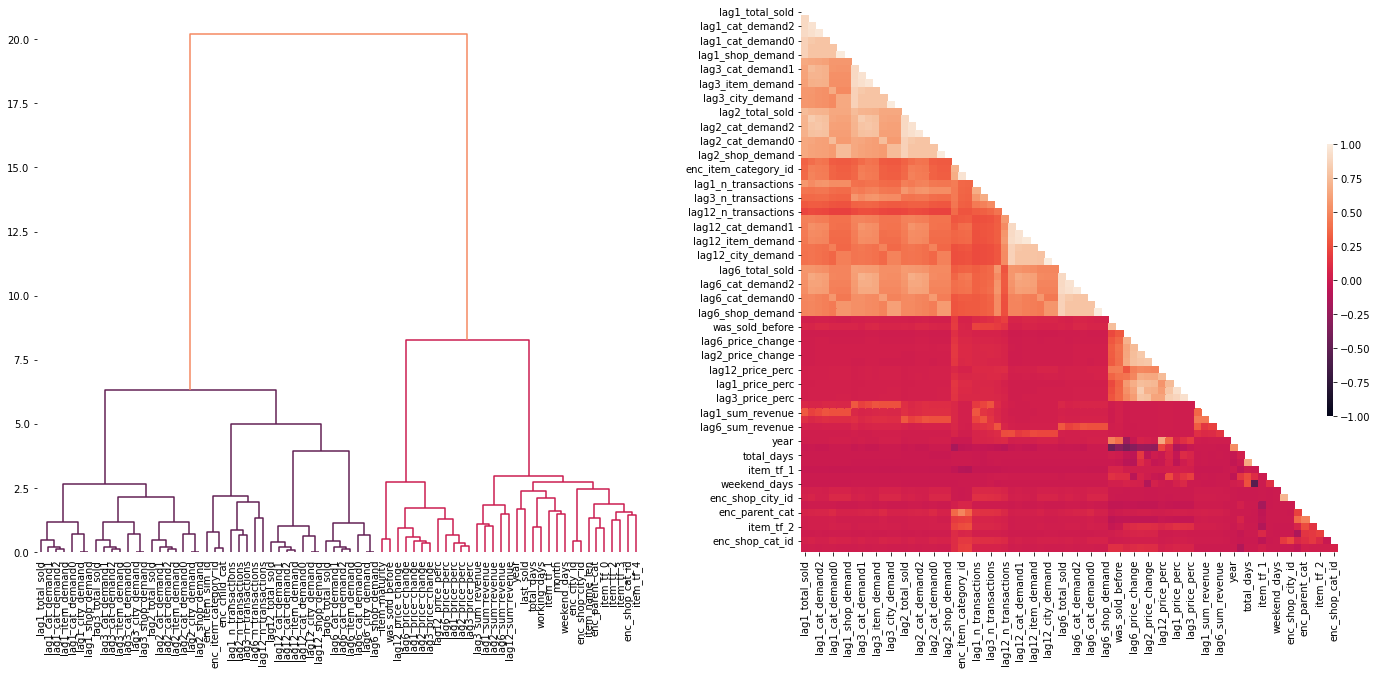

In [25]:
# take a peek at feature similarity
from scipy.cluster import hierarchy
corr_mat=sales.loc[:,features].corr()
corr_linkage = hierarchy.ward(corr_mat)
fig, axs = plt.subplots(1, 2, figsize=(25, 10),
  gridspec_kw={"width_ratios": [1, 1.15], "wspace":0.15})
color_links = [rgb2hex(c) for c in sns.color_palette("rocket", n_colors=3)]
hierarchy.set_link_color_palette(color_links)
dendro = hierarchy.dendrogram(corr_linkage, labels=corr_mat.columns,
    ax=axs[0], leaf_font_size=10, leaf_rotation=90,
    above_threshold_color=color_links[2])
hierarchy.set_link_color_palette(None)    
for s in axs[0].spines.keys():
    axs[0].spines[s].set_visible(False)
dendro_idx = np.arange(0, len(dendro["ivl"]))
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(corr_mat.iloc[dendro["leaves"], :].iloc[:, dendro["leaves"]],
    ax=axs[1], vmin=-1, vmax=1, mask=mask, square=True,
    cbar_kws={"aspect":50, "shrink":0.5, "pad":-0.025,
      "ticks":[-1,-.75,-0.5,-0.25,0,0.25,0.5,.75,1]}, annot_kws={"size":10})
axs[1].set_ylabel(""); axs[1].set_xlabel("");

In [26]:
# remove very similar feats
from collections import defaultdict
cluster_ids = hierarchy.fcluster(corr_linkage, .10, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
fs = [v[0] for v in cluster_id_to_feature_ids.values()]
features = corr_mat.columns[fs]
corr_mat.columns[fs] # print-out what is left

Index(['enc_item_category_id', 'enc_item_sim_id', 'enc_parent_cat',
       'enc_child_cat', 'enc_city_id', 'enc_shop_cat_id', 'enc_shop_city_id',
       'item_name_len', 'item_tf_0', 'item_tf_1', 'item_tf_2', 'item_tf_3',
       'item_tf_4', 'year', 'month', 'total_days', 'working_days',
       'weekend_days', 'item_maturity', 'last_sold', 'was_sold_before',
       'lag1_total_sold', 'lag1_sum_revenue', 'lag1_n_transactions',
       'lag1_price_change', 'lag1_price_perc', 'lag1_city_demand',
       'lag1_cat_demand0', 'lag1_cat_demand1', 'lag1_cat_demand2',
       'lag1_item_demand', 'lag2_total_sold', 'lag2_sum_revenue',
       'lag2_n_transactions', 'lag2_price_change', 'lag2_price_perc',
       'lag2_city_demand', 'lag2_cat_demand0', 'lag2_cat_demand1',
       'lag2_cat_demand2', 'lag2_item_demand', 'lag3_total_sold',
       'lag3_sum_revenue', 'lag3_n_transactions', 'lag3_price_change',
       'lag3_price_perc', 'lag3_city_demand', 'lag3_cat_demand0',
       'lag3_cat_demand1', 'la

In [27]:
corr_target = sales[features.union([target])].corr()[target]
print("\nHigh positive corr>")
display(corr_target.sort_values().tail(10))
print("\nHigh negative corr>")
display(corr_target.sort_values().head(10))
print("\nLow corr>")
display(corr_target.abs().sort_values().head(10))


High positive corr>


lag1_cat_demand0       0.362589
lag6_n_transactions    0.367246
lag1_cat_demand2       0.376386
lag1_total_sold        0.380115
lag1_item_demand       0.387614
enc_item_sim_id        0.409584
lag3_n_transactions    0.462537
lag2_n_transactions    0.523173
lag1_n_transactions    0.619196
total_sold             1.000000
Name: total_sold, dtype: float64


High negative corr>


item_tf_1            -0.028033
last_sold            -0.020422
working_days          0.003020
weekend_days          0.006146
total_days            0.009025
item_name_len         0.011713
month                 0.023049
item_tf_3             0.038728
year                  0.043295
lag12_price_change    0.057697
Name: total_sold, dtype: float64


Low corr>


working_days          0.003020
weekend_days          0.006146
total_days            0.009025
item_name_len         0.011713
last_sold             0.020422
month                 0.023049
item_tf_1             0.028033
item_tf_3             0.038728
year                  0.043295
lag12_price_change    0.057697
Name: total_sold, dtype: float64

In [28]:
# check variability
sales[features].var().sort_values().T.head(10)

item_tf_4           0.003941
item_tf_3           0.004501
item_tf_1           0.005603
item_tf_2           0.007054
enc_city_id         0.008967
item_tf_0           0.011145
enc_shop_cat_id     0.016532
enc_shop_city_id    0.017296
enc_parent_cat      0.025867
enc_child_cat       0.094866
dtype: float64

In [29]:
low_feat_filter = set(corr_target.abs().sort_values()[:10].index).\
  intersection(set(sales[features].var().sort_values().T[:10].index))
low_feat_filter= {}

In [ ]:
sales = optimize_numeric_dtypes(sales)

In [ ]:
from sklearn.feature_selection import f_regression, mutual_info_regression
mir = mutual_info_regression(sales[features], sales[target])

In [31]:
# remove low correlated features (as they are also low in var)
#features = [f for f in features if f not in low_feat_filter]
 # just remove some of the bs
sales = sales[sales.date_block_num>11]


## Modeling pipeline

In [31]:
import lightgbm as lgbm
import catboost as cat
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
# stage filters
b_ind =  sales.date_block_num==32 # 2nd stage 
c_ind =  sales.date_block_num==33 # eval
test_ind =  sales.date_block_num==34 # prediction
a_ind = ~b_ind & ~c_ind & ~test_ind # 1st stage

In [ ]:
stack_train_ind = np.logical_or(a_ind,b_ind)
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor,\
  HistGradientBoostingRegressor, StackingRegressor
l0 = [("gbm", HistGradientBoostingRegressor()),
  ("rf", RandomForestRegressor(),
  ("et", ExtraTreesRegressor()))]
l1 = RidgeCV()
stack = StackingRegressor(estimators=l0, final_estimator=l1, cv=5, n_jobs=1)
stack.fit(sales.loc[stack_train_ind,features], sales.loc[stack_train_ind,target])

In [ ]:
# stack eval
stack_c_feature = stack.predict(sales.loc[c_ind,features])

stack_mse = mean_squared_error(sales.loc[c_ind,target], stack_c_feature)
stack_r2 = r2_score(sales.loc[c_ind,target], stack_c_feature)
print("Stack shows MSE {:.2f} and R2 {:.2f} on the c set.".format(stack_mse, stack_r2))

### First stage models

In [33]:
# lightgbm
lgbm_model = lgbm.LGBMRegressor(n_estimators=500, learning_rate=.075, max_depth=5,
  objective="mse", device="gpu")
lgbm_model.fit(sales.loc[a_ind,features], sales.loc[a_ind,target],
  eval_set=(sales.loc[np.logical_or(b_ind, c_ind),features],
    sales.loc[np.logical_or(b_ind, c_ind),target]),
  callbacks=[lgbm.early_stopping(stopping_rounds=10)])

# pushout preds
lgbm_b_feature = lgbm_model.predict(sales.loc[b_ind,features])#.clip(0,20)
lgbm_c_feature = lgbm_model.predict(sales.loc[c_ind,features])#.clip(0,20)
lgbm_test_feature = lgbm_model.predict(sales.loc[test_ind,features])#.clip(0,20)

# print test score
lgbm_mse = mean_squared_error(sales.loc[c_ind,target], lgbm_c_feature)
lgbm_r2 = r2_score(sales.loc[c_ind,target], lgbm_c_feature)
print("LGBM shows MSE {:.2f} and R2 {:.2f} on the c set.".format(lgbm_mse, lgbm_r2))

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[350]	valid_0's l2: 0.625778
LGBM shows MSE 0.63 and R2 0.47 on the c set.


In [34]:
!pip install optuna

In [48]:
# skelet for evaluation

import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

def objective(trial, X, y):
  param_grid = {
        "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        )}
  cv = KFold(n_splits=5, shuffle=True, random_state=1121218)

  cv_scores = np.empty(5)
  for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model = lgbm.LGBMClassifier(objective="mse", **param_grid)
    model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="mse", early_stopping_rounds=100)
    preds = model.predict_proba(X_test)
    cv_scores[idx] = preds

  return np.mean(cv_scores)


In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial,sales.loc[a_ind,features].values, sales.loc[a_ind,target].values)
study.optimize(func, n_trials=20)

[I 2022-04-02 07:42:57,940] A new study created in memory with name: LGBM Regressor


In [33]:
# rf
rf_model = lgbm.LGBMRegressor(boosting_type="rf", n_estimators=500, max_depth=5,
  objective="mse", subsample=.8, colsample_bytree=.8, subsample_freq=1, device="gpu")
rf_model.fit(sales.loc[a_ind,features], sales.loc[a_ind,target])

# pushout preds
rf_b_feature = rf_model.predict(sales.loc[b_ind,features])#.clip(0,20)
rf_c_feature = rf_model.predict(sales.loc[c_ind,features])#.clip(0,20)
rf_test_feature = rf_model.predict(sales.loc[test_ind,features])#.clip(0,20)

rf_mse = mean_squared_error(sales.loc[c_ind,target], rf_c_feature)
rf_r2 = r2_score(sales.loc[c_ind,target], rf_c_feature)
print("RF shows MSE {:.2f} and R2 {:.2f} on the c set.".format(rf_mse, rf_r2))

RF shows MSE 0.75 and R2 0.36 on the c set.


In [34]:
# catboost on raw data
cb_features = [f.replace("enc_", "") for f in features]
cat_model = cat.CatBoostRegressor(early_stopping_rounds=10,
  learning_rate=.025, max_depth=7, bagging_temperature=3,#subsample=.75, #colsample_bylevel=.75,
  eval_metric="RMSE", task_type="GPU", cat_features=cat_cols)
cat_model.fit(sales.loc[a_ind,cb_features], sales.loc[a_ind,target],
  eval_set=(sales.loc[np.logical_or(b_ind, c_ind),cb_features],
    sales.loc[np.logical_or(b_ind, c_ind),target]),
  verbose=100)

# pushout preds
cat_b_feature = cat_model.predict(sales.loc[b_ind,cb_features])#.clip(0,20)
cat_c_feature = cat_model.predict(sales.loc[c_ind,cb_features])#.clip(0,20)
cat_test_feature = cat_model.predict(sales.loc[test_ind,cb_features])#.clip(0,20)

cat_mse = mean_squared_error(sales.loc[c_ind,target], cat_c_feature)
cat_r2 = r2_score(sales.loc[c_ind,target], cat_c_feature)
print("Catboost shows MSE {:.2f} and R2 {:.2f} on the c set.".format(cat_mse, cat_r2))

0:	learn: 1.0907330	test: 1.0931300	best: 1.0931300 (0)	total: 353ms	remaining: 5m 53s
100:	learn: 0.7576736	test: 0.8608861	best: 0.8608861 (100)	total: 39.7s	remaining: 5m 53s
200:	learn: 0.7260363	test: 0.8509992	best: 0.8509992 (200)	total: 1m 19s	remaining: 5m 14s
300:	learn: 0.7120545	test: 0.8463653	best: 0.8463653 (300)	total: 1m 58s	remaining: 4m 34s
400:	learn: 0.7034347	test: 0.8417597	best: 0.8417597 (400)	total: 2m 36s	remaining: 3m 54s
bestTest = 0.8416600798
bestIteration = 406
Shrink model to first 407 iterations.
Catboost shows MSE 0.68 and R2 0.42 on the c set.


### Second stage model

In [35]:
from sklearn.linear_model import RidgeCV,BayesianRidge

In [36]:
b_features = np.stack([lgbm_b_feature, rf_b_feature, cat_b_feature], axis=1)
c_features = np.stack([lgbm_c_feature, rf_c_feature, cat_c_feature], axis=1)
test_features = np.stack([lgbm_test_feature, rf_test_feature, cat_test_feature], axis=1)

lr_model = BayesianRidge()
lr_model.fit(b_features, sales.loc[b_ind,target])



train_rsme = np.mean((lr_model.predict(b_features).clip(0,20)-sales.loc[b_ind,target])**2)**(1/2)
val_rsme = np.mean((lr_model.predict(c_features).clip(0,20)-sales.loc[c_ind,target])**2)**(1/2)
print("Stacked pipeline> RMSE on train set: {}; on val set: {}".format(train_rsme, val_rsme))
lr_model.coef_

Stacked pipeline> RMSE on train set: 0.7839276207067534; on val set: 0.7940457893074899


array([ 1.60155166, -0.20280874, -0.38344792])

In [37]:
# restack
stacked_features = np.concatenate([b_features, c_features], axis=0)
stacked_target = np.concatenate([sales.loc[b_ind,target].values,
  sales.loc[c_ind,target].values], axis=0)
lr_model.fit(stacked_features, stacked_target)
lr_model.coef_

array([ 1.46175025, -0.18787276, -0.27802115])

In [38]:
test_mapping = pd.read_csv(DATA_DIR+"test.csv")
test_predictions = sales.loc[test_ind,["item_id", "shop_id"]]
test_predictions["item_cnt_month"] = lr_model.predict(test_features).clip(0,20)
test_predictions = test_mapping.merge(test_predictions, on=["item_id", "shop_id"],how="left").fillna(0)
test_predictions[["ID", "item_cnt_month"]].to_csv("data/submissions/submission.csv", index=False)
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f data/submissions/submission.csv -m "Remove 20 lcorr features."

100% 4.51M/4.51M [00:00<00:00, 14.9MB/s]
Successfully submitted to Predict Future Sales

## Submission